In [1]:
import sys
sys.prefix

'/Users/adamjedrzejewski/opt/anaconda3/envs/suml_task4'

In [2]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import fastbook

from fastbook import *
from fastai.vision.widgets import *
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

/Users/adamjedrzejewski/opt/anaconda3/envs/suml_task4/lib/python3.10/site-packages/fastbook/__init__.py:13: UserWarning: Missing `sentencepiece` - please run `pip install 'sentencepiece<0.1.90'`
  except ModuleNotFoundError: warn("Missing `sentencepiece` - please run `pip install 'sentencepiece<0.1.90'`")


In [3]:
dataset_dir = './dataset'
male_eyes = f'{dataset_dir}/maleeyes'
female_eyes = f'{dataset_dir}/femaleeyes'

## create dataframe

In [4]:
male_eyes_files = [[os.path.join(male_eyes, filename), 'male'] for filename in os.listdir(male_eyes)]
female_eyes_files = [[os.path.join(female_eyes, filename), 'female'] for filename in os.listdir(female_eyes)]

balance the data

In [5]:
len(male_eyes_files)

6323

In [6]:
len(female_eyes_files)

5202

In [7]:
male_eyes_files = male_eyes_files[:5202]

In [8]:
len(male_eyes_files) == len(female_eyes_files)

True

In [9]:
eyes_files = male_eyes_files + female_eyes_files

In [10]:
df = pd.DataFrame(eyes_files, columns=['image_path', 'label'])

In [11]:
df.describe()

,image_path,label
count,10404,10404
unique,10404,2
top,./dataset/maleeyes/63.jpg,male
freq,1,5202


In [12]:
df = df.sample(frac=1).reset_index(drop=True)

In [13]:
df

,image_path,label
0,./dataset/femaleeyes/6660.jpg,female
1,./dataset/femaleeyes/3028.jpg,female
2,./dataset/femaleeyes/7087.jpg,female
3,./dataset/maleeyes/3968.jpg,male
4,./dataset/maleeyes/5594.jpg,male
...,...,...
10399,./dataset/femaleeyes/2076.jpg,female
10400,./dataset/maleeyes/4209.jpg,male
10401,./dataset/femaleeyes/5097.jpg,female
10402,./dataset/maleeyes/1143.jpg,male


In [14]:
df.isna().any()

image_path    False
label         False
dtype: bool

## explore the images

In [15]:
female_eye = df[df['label'] == 'female'].iloc[0]['image_path']
male_eye = df[df['label'] == 'male'].iloc[0]['image_path']

Text(0.5, 1.0, 'female eye')

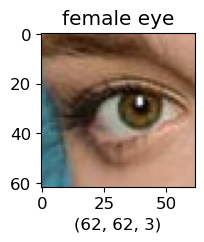

In [16]:
figure = plt.figure(figsize=(2,2))
image = plt.imread(female_eye)
plt.imshow(image)
plt.xlabel(image.shape)
plt.title('female eye')

Text(0.5, 1.0, 'male eye')

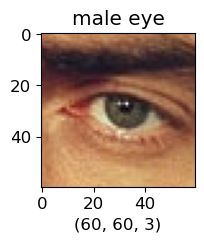

In [17]:
figure = plt.figure(figsize=(2,2))
image = plt.imread(male_eye)
plt.imshow(image)
plt.xlabel(image.shape)
plt.title('male eye')

Those two samples have different sizes, let's resize all images to the same size for better classification

In [18]:
size_set = set()
for image in df['image_path']:
    x, y, _ = plt.imread(image).shape
    size_set.add((x,y))
len(size_set)

66

In [19]:
sorted_sizes = list(sorted(size_set))
smallest_image = sorted_sizes[0]
largest_image = sorted_sizes[-1]

In [20]:
print('smallest: ', smallest_image)
print('largest:', largest_image)

smallest:  (41, 41)
largest: (117, 117)


In [21]:
df_1 = df.copy()
df_1 = df_1.rename(columns={'image_path':'image'})

In [22]:
size = (41, 41)
for i in range(len(df)):
    image = cv2.imread(df['image_path'][i])
    image = cv2.resize(image, size)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    df_1['image'][i] = image.flatten()

In [23]:
df_1.head()

,image,label
0,"[140, 102, 75, 112, 75, 43, 105, 72, 36, 98, 68, 35, 97, 64, 34, 90, 55, 27, 91, 54, 29, 85, 49, 25, 87, 53, 29, 94, 58, 35, 104, 68, 45, 105, 69, 47, 106, 71, 51, 110, 76, 56, 103, 68, 47, 94, 60, 39, 96, 63, 40, 92, 58, 38, 113, 79, 58, 120, 86, 62, 120, 81, 58, 127, 85, 60, 136, 91, 68, 142, 97, 74, 147, 103, 80, 142, 97, 74, 144, 101, 77, 170, 127, 102, 188, 143, 119, 197, 153, 128, 201, 158, 133, 197, 149, 126, 199, 153, 129, 213, ...]",female
1,"[240, 195, 155, 237, 193, 156, 235, 191, 154, 238, 192, 156, 240, 194, 158, 241, 192, 158, 240, 192, 156, 239, 188, 154, 241, 188, 156, 240, 187, 155, 229, 174, 140, 223, 165, 131, 221, 164, 122, 217, 157, 118, 214, 150, 115, 208, 143, 111, 192, 127, 97, 180, 115, 85, 172, 107, 78, 160, 100, 71, 137, 81, 53, 129, 75, 49, 125, 70, 49, 118, 66, 47, 116, 65, 49, 120, 69, 52, 120, 71, 54, 116, 68, 51, 119, 70, 53, 119, 67, 51, 120, 66, 53, 126, 73, 59, 123, 69, 53, 136, ...]",female
2,"[222, 221, 198, 223, 227, 205, 221, 231, 207, 220, 228, 205, 221, 225, 207, 222, 228, 210, 221, 227, 210, 227, 231, 220, 230, 236, 226, 225, 232, 220, 224, 228, 216, 229, 231, 221, 234, 239, 229, 231, 239, 228, 232, 239, 230, 240, 246, 242, 238, 245, 243, 237, 244, 246, 244, 250, 252, 246, 250, 252, 243, 247, 248, 241, 249, 250, 238, 248, 245, 240, 246, 242, 238, 248, 236, 234, 243, 227, 228, 237, 222, 225, 236, 220, 229, 237, 222, 230, 232, 217, 223, 224, 207, 223, 226, 206, 219, 222, 202, 215, ...]",female
3,"[184, 120, 83, 186, 124, 88, 189, 135, 93, 198, 151, 104, 212, 163, 116, 212, 160, 113, 200, 146, 100, 193, 138, 94, 189, 134, 93, 192, 136, 96, 198, 140, 100, 194, 136, 96, 193, 137, 96, 187, 129, 90, 194, 136, 96, 193, 137, 96, 195, 143, 101, 189, 138, 94, 200, 145, 106, 196, 141, 104, 183, 129, 92, 186, 133, 96, 177, 123, 85, 174, 121, 82, 182, 129, 91, 182, 127, 90, 183, 129, 91, 179, 126, 85, 179, 126, 89, 175, 123, 90, 162, 112, 81, 149, 98, 72, 124, 75, 50, 141, ...]",male
4,"[223, 217, 193, 223, 217, 193, 223, 218, 196, 225, 219, 197, 227, 221, 199, 228, 222, 200, 227, 222, 202, 229, 223, 203, 231, 224, 205, 233, 228, 208, 234, 229, 209, 235, 230, 210, 235, 230, 210, 234, 229, 209, 234, 229, 209, 235, 230, 208, 232, 229, 208, 233, 228, 208, 234, 229, 210, 235, 228, 210, 235, 230, 211, 231, 228, 209, 231, 228, 209, 232, 227, 208, 231, 226, 207, 232, 227, 208, 232, 228, 208, 234, 229, 210, 234, 228, 210, 234, 229, 210, 233, 229, 209, 231, 228, 207, 233, 227, 207, 234, ...]",male


## CNN model

encode labels

In [24]:
train_df, test_df = train_test_split(df_1, test_size=0.2, random_state=2)

In [25]:
data = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2,seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

In [26]:
dls = data.dataloaders(dataset_dir, bs = 32, num_workers = 0)

TypeError: Instance and class checks can only be used with @runtime_checkable protocols